C:\Users\Asus\AppData\Local\Temp\ipykernel_20416\3543129990.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_20416\3543129990.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Mg_Number'].fillna

Success! Plot saved as 'mg_number_harker_plots.png'


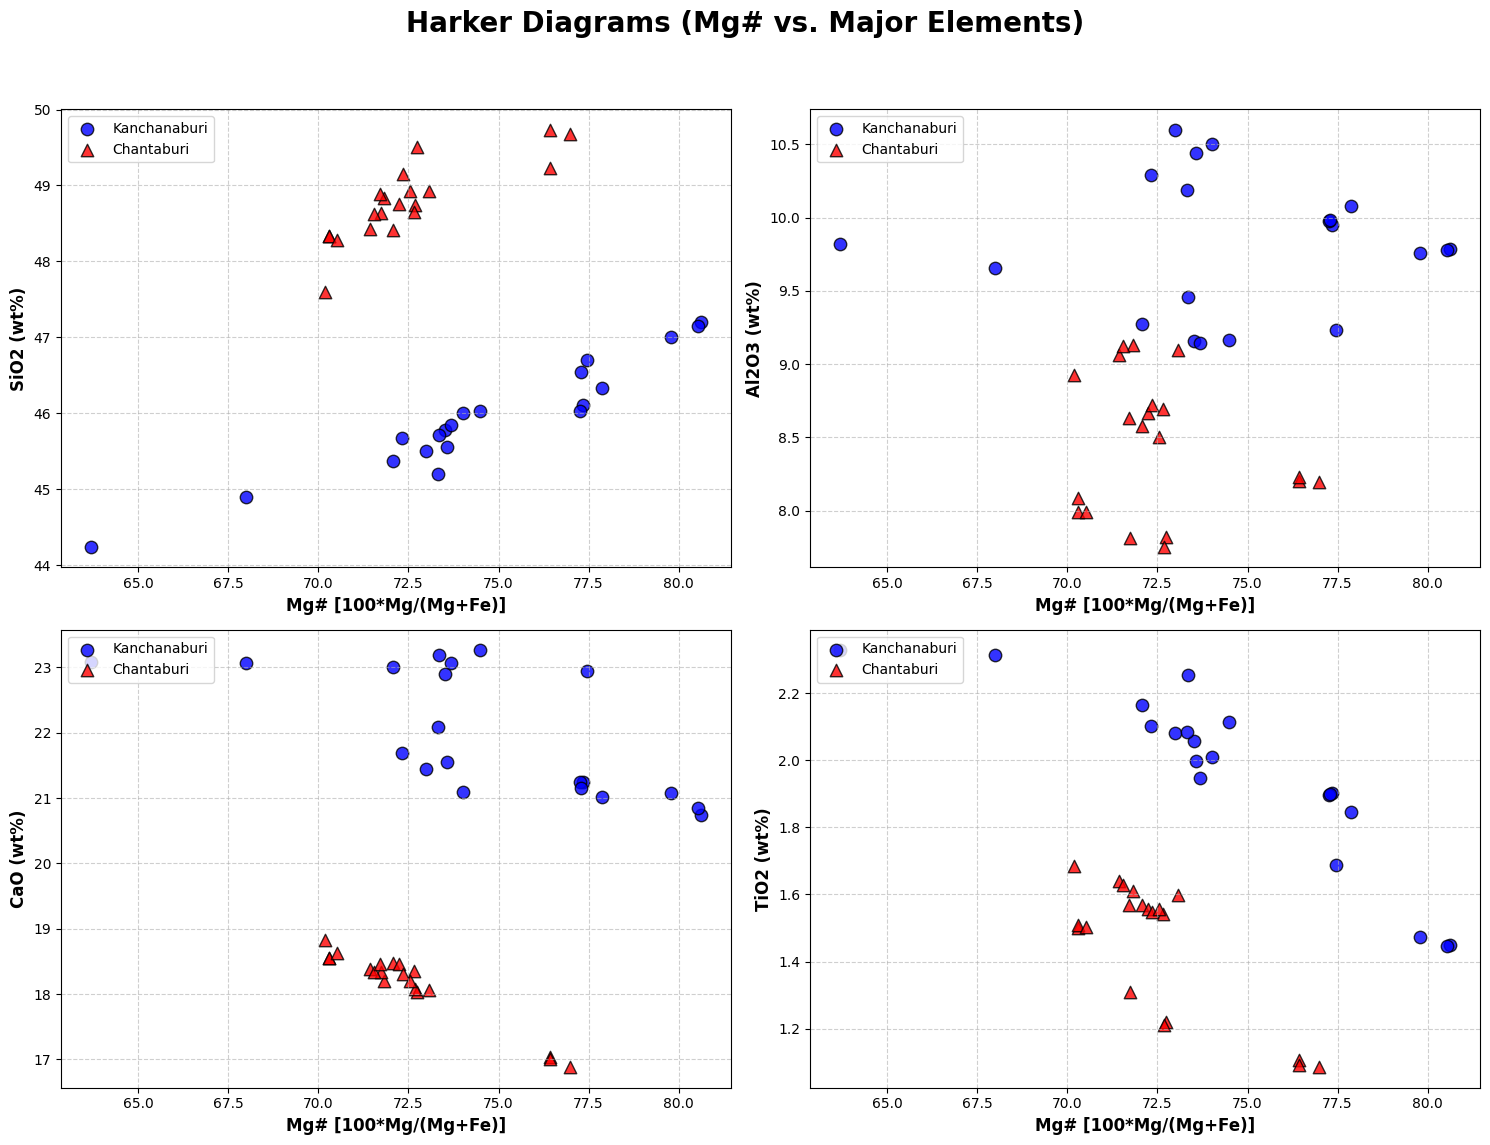

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Data Loading and Cleaning Functions ---

def load_and_clean_data(filepath, location_name):
    """
    Reads the specific EDXRF CSV format.
    Structure:
    Row 0: Empty
    Row 1: Title
    Row 2: Headers (No., Sample, etc.) -> We use header=2
    """
    try:
        df = pd.read_csv(filepath, header=2)
        
        # Clean column names (strip whitespace)
        df.columns = df.columns.str.strip()
        
        # Filter meaningful rows based on 'No.' column being numeric
        valid_rows = pd.to_numeric(df['No.'], errors='coerce').notnull()
        df = df[valid_rows].copy()
        
        # Select all relevant oxide columns for Harker plots
        oxides = ['MgO', 'Fe2O3', 'SiO2', 'Al2O3', 'CaO', 'TiO2'] 
        
        for col in oxides:
            if col not in df.columns:
                return pd.DataFrame() 
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
        df['Location'] = location_name
        return df
    except FileNotFoundError:
        return pd.DataFrame()
    except Exception as e:
        return pd.DataFrame()

# --- 2. Mg# Calculation ---

def calculate_mg_number(df):
    """
    Calculates the molar Mg# [100 * Mg / (Mg + Fe)].
    
    Molecular Weights:
    MgO: 40.3044
    Fe2O3: 159.69 (Total Iron)
    """
    if df.empty:
        return df
        
    mw_MgO = 40.3044
    mw_Fe2O3 = 159.69
    
    # Calculate Moles
    df['mol_Mg'] = df['MgO'] / mw_MgO
    # Fe2O3 has 2 Fe atoms, so multiply moles of oxide by 2
    df['mol_Fe_tot'] = (df['Fe2O3'] / mw_Fe2O3) * 2
    
    # Calculate Mg#
    df['Mg_Number'] = 100 * (df['mol_Mg'] / (df['mol_Mg'] + df['mol_Fe_tot']))
    
    # Handle potential division by zero if both Mg and Fe are 0
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df['Mg_Number'].fillna(0, inplace=True)
    
    return df

# --- 3. Main Execution ---

def main():
    kan = load_and_clean_data('Kanchanaburi.csv', 'Kanchanaburi')
    chan = load_and_clean_data('Chantaburi.csv', 'Chantaburi')

    if kan.empty and chan.empty:
        return
        
    # Calculate Mg# for both datasets
    kan = calculate_mg_number(kan)
    chan = calculate_mg_number(chan)

    # --- Create the 2x2 Plot Grid ---
    # fig is the whole window, axes is a 2x2 array of plot objects
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # List of elements to plot on the y-axes
    y_elements = ['SiO2', 'Al2O3', 'CaO', 'TiO2']
    
    # Flatten the 2x2 array of axes into a 1D list for easy looping
    ax_list = axes.flatten()
    
    for ax, element in zip(ax_list, y_elements):
        # Plot Kanchanaburi data
        if not kan.empty:
            ax.scatter(kan['Mg_Number'], kan[element], 
                       c='blue', 
                       label='Kanchanaburi', 
                       s=80, 
                       edgecolor='black', 
                       alpha=0.8, 
                       marker='o')

        # Plot Chantaburi data
        if not chan.empty:
            ax.scatter(chan['Mg_Number'], chan[element], 
                       c='red', 
                       label='Chantaburi', 
                       s=80, 
                       edgecolor='black', 
                       alpha=0.8, 
                       marker='^')
                       
        # --- Style each individual plot ---
        ax.set_xlabel('Mg# [100*Mg/(Mg+Fe)]', fontsize=12, weight='bold')
        ax.set_ylabel(f'{element} (wt%)', fontsize=12, weight='bold')
        ax.legend(loc='upper left', frameon=True, fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)

    # Add a main title to the entire figure
    fig.suptitle('Harker Diagrams (Mg# vs. Major Elements)', fontsize=20, weight='bold')
    
    # Adjust layout to prevent title overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.savefig('mg_number_harker_plots.png', dpi=300, bbox_inches='tight')
    print("Success! Plot saved as 'mg_number_harker_plots.png'")
    plt.show()

if __name__ == "__main__":
    main()